# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [134]:
import numpy as np
import pandas as pd
import random
import os
from datetime import date
from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline
DATA_FOLDER = '/Users/sandra/Desktop/ADA/ADA2017-Tutorials/02 - Intro to Pandas/Data'


## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### A) Pre-processing data

In [135]:
GUINEA_PATH  = DATA_FOLDER + '/ebola/guinea_data/'
LIBERIA_PATH = DATA_FOLDER + '/ebola/liberia_data/'
SL_PATH      = DATA_FOLDER + '/ebola/sl_data/'

"""Read data"""

GUINEA_DATAS  = [pd.read_csv(GUINEA_PATH  + file) for file in os.listdir( GUINEA_PATH ) if file.endswith(".csv")]
LIBERIA_DATAS = [pd.read_csv(LIBERIA_PATH + file) for file in os.listdir( LIBERIA_PATH )if file.endswith(".csv")]
SL_DATAS      = [pd.read_csv(SL_PATH      + file) for file in os.listdir( SL_PATH )     if file.endswith(".csv")]

In [136]:
"""Concatenate all files of each country and replace missing value by zero"""

GUINEA_dframes  = pd.concat(GUINEA_DATAS)
LIBERIA_dframes = pd.concat(LIBERIA_DATAS)
SL_dframes      = pd.concat(SL_DATAS)

GUINEA_dframes  = GUINEA_dframes .fillna(0)
LIBERIA_dframes = LIBERIA_dframes.fillna(0)
SL_dframes      = SL_dframes     .fillna(0)

In [137]:
"""First of all, take a look at data header and decide which columns are useful"""

GUINEA_dframes  = GUINEA_dframes [['Date', 'Description', 'Totals']]
LIBERIA_dframes = LIBERIA_dframes[['Date', 'Variable', 'National']]
SL_dframes      = SL_dframes     [['date', 'variable', 'National']]

In [138]:
"""Rename for having the same format"""

LIBERIA_dframes = LIBERIA_dframes.rename(index=str, columns={"Variable": "Description", "National": "Totals"})
SL_dframes      = SL_dframes.     rename(index=str, columns={"date": "Date","variable": "Description", "National": "Totals"})

In [139]:
"""Change format Date of data provided by LIBERIA"""
"""Change 6/16/2014 (MM/DD/YYYY) to 2014-06-16 (YYYY-MM-DD)"""
"""Attention with data '6/16/17' 17 means 2017 :)"""

def changeDateFormat(date):
    string = date.split('/')
    if (len(string[0]) == 1) : string[0] = '0' + string[0]
    if (len(string[1]) == 1) : string[1] = '0' + string[1]
    if (len(string[2]) == 2) : string[2] = '20'+ string[2]
    return string[2] + '-' + string[0] + '-' + string[1]

LIBERIA_dframes['Date'] = LIBERIA_dframes['Date'].apply(lambda x : changeDateFormat(str(x)))

In [140]:
"""Parsing string Date to object TimeDate"""

def parseDate(string):
    result = pd.to_datetime(string, format='%Y-%m-%d', errors='coerce')
    if (type(result) is pd.tslib.NaTType):
        print('Problem man !!!')
    return result

GUINEA_dframes ['Date'] = GUINEA_dframes ['Date'].apply(lambda x : parseDate(str(x)))
LIBERIA_dframes['Date'] = LIBERIA_dframes['Date'].apply(lambda x : parseDate(str(x)))
SL_dframes     ['Date'] = SL_dframes     ['Date'].apply(lambda x : parseDate(str(x)))

In [141]:
"""Insert an extra column Country"""

GUINEA_dframes .insert(3, 'Country', 'GUINEA')
LIBERIA_dframes.insert(3, 'Country', 'LIBERIA')
SL_dframes     .insert(3, 'Country', 'SL')

In [142]:
"""Set indexes"""

GUINEA_dframes.index  = range(len(GUINEA_dframes))
LIBERIA_dframes.index = range(len(LIBERIA_dframes))
SL_dframes.index      = range(len(SL_dframes))


In [143]:
"""Drop all non-integer elements in column 'Totals'"""

GUINEA_dframes  = GUINEA_dframes[ GUINEA_dframes  ['Totals'].apply(lambda x: str(x).isdigit())]
#LIBERIA_dframes = LIBERIA_dframes[ LIBERIA_dframes['Totals'].apply(lambda x: x.isdigit() or str(x).isdigit())]
SL_dframes      = SL_dframes[ SL_dframes          ['Totals'].apply(lambda x: str(x).isdigit())]

In [144]:
"""Convert all integer of type string into integer"""

GUINEA_dframes ['Totals'] = pd.to_numeric( GUINEA_dframes ['Totals'], errors='coerce')
LIBERIA_dframes['Totals'] = pd.to_numeric( LIBERIA_dframes['Totals'], errors='coerce')
SL_dframes     ['Totals'] = pd.to_numeric( SL_dframes     ['Totals'], errors='coerce')

### B) Computation

#### GUINEA
In reports of GUINEA, there are 2 types of new cases: 
* 'Total new cases' (with a litle 'n' in new cases).
* 'New cases' (with a capital 'N' in New cases) which is relevant because we can take into account the case 'New cases of confirmed..' too.



How do I compute the average ? Well, for each month, I count the total 'New cases' and then devided it by the number of days reported in this month. Par example, in August we have the total of 'New cases' is 300 and it is reported in 3 days. Then we have the average is 300/3 = 100.

In [145]:
print('The daily average per month of new cases')

"""Find key New cases"""
GUINEA_newcases = GUINEA_dframes[ [('New cases' in desc) for desc in GUINEA_dframes.Description]]

"""Groupby Month for being able to aggregate in Totals"""
daily = GUINEA_newcases.set_index(['Date']).groupby(pd.TimeGrouper('M'))

"""Groupby Date for being able to count number of days reported in a month"""
days = GUINEA_newcases.groupby(GUINEA_newcases.Date)
arr = np.array(list(days.groups.keys()))
arr = [x.month for x in arr]


"""Sum over month divided by number of days (length of keys)"""

timestamps = list(daily.groups.keys())
sums = daily.Totals.sum()
nbMonths = len(timestamps)
for i in range(nbMonths):
    month = timestamps[i].month
    print("The average 'new cases' on month {m} is {v}"
              .format(m=month, v=sums[i]/arr.count(month)))


The daily average per month of new cases
The average 'new cases' on month 8 is 25.8
The average 'new cases' on month 9 is 20.0625
The average 'new cases' on month 10 is 36.0


For me, a confirmation of a death is valided. So I count only the cases that have the key 'confirmed'

In [146]:
print('The daily average per month of deaths')

GUINEA_deaths = GUINEA_dframes[ [('confirmed' in desc and 
                                  'deaths'    in desc and 
                                  'Total deaths (confirmed + probables + suspects)' not in desc or    
                                  (   'deaths registered' in desc and
                                      '(confirmed)'   not in desc and
                                      '(probables)'   not in desc and
                                      '(suspects)'    not in desc 
                                  )
                                ) for desc in GUINEA_dframes.Description]]

"""Groupby Month for being able to aggregate in Totals"""
daily = GUINEA_deaths.set_index(['Date']).groupby(pd.TimeGrouper('M'))

"""Groupby Date for being able to count number of days reported in a month"""
days = GUINEA_deaths.groupby(GUINEA_deaths.Date)
arr = np.array(list(days.groups.keys()))
arr = [x.month for x in arr]


"""Sum over month divided by number of days (length of keys)"""

timestamps = list(daily.groups.keys())
sums = daily.Totals.sum()
nbMonths = len(timestamps)
for i in range(nbMonths):
    month = timestamps[i].month
    print("The average 'deaths' of month {m} is {v}"
              .format(m=month, v=sums[i]/arr.count(month)))

The daily average per month of deaths
The average 'deaths' of month 8 is 349.6
The average 'deaths' of month 9 is 485.8125
The average 'deaths' of month 10 is 612.0


#### LIBERIA

The same idea here, in the data we have 4 different words: *New cases*, *New case*, *New Case*, *New Cases*. So we just need to collect all new cases and compute

In [147]:
""""""
print('The daily average per month of deaths')


LIBERIA_newcases = LIBERIA_dframes[ [('New cases' in desc  or 
                                      'New case'  in desc  or
                                      'New Case'  in desc  or
                                      'New Cases' in desc 
                                     ) for desc in LIBERIA_dframes.Description]]


"""Groupby Month for being able to aggregate in Totals"""
daily = LIBERIA_newcases.set_index(['Date']).groupby(pd.TimeGrouper('M'))

"""Groupby Date for being able to count number of days reported in a specific month"""
days = LIBERIA_newcases.groupby(LIBERIA_newcases.Date)
arr = np.array(list(days.groups.keys()))
arr = [x.month for x in arr]


"""Sum over month divided by number of days (length of keys)"""

timestamps = list(daily.groups.keys())
sums = daily.Totals.sum()
nbMonths = len(timestamps)
for i in range(nbMonths):
    month = timestamps[i].month
    print("The average 'new cases' on month {m} is {v}"
              .format(m=month, v=sums[i]/arr.count(month)))

The daily average per month of deaths
The average 'new cases' on month 6 is 5.714285714285714
The average 'new cases' on month 7 is 8.545454545454545
The average 'new cases' on month 8 is 37.22222222222222
The average 'new cases' on month 9 is 63.833333333333336
The average 'new cases' on month 10 is 45.56
The average 'new cases' on month 11 is 26.466666666666665
The average 'new cases' on month 12 is 5178.555555555556


In [148]:
LIBERIA_deaths = LIBERIA_dframes[ [( 'deaths' in desc  or 
                                     'death'  in desc  and                                     
                                       'Total death/s in confirmed cases' not in desc and
                                    'Total death/s in probable cases' not in desc and
                                    'Total death/s in suspected cases' not in desc 
                                   ) for desc in LIBERIA_dframes.Description]]

"""Groupby Month for being able to aggregate in Totals"""
daily = LIBERIA_deaths.set_index(['Date']).groupby(pd.TimeGrouper('M'))

"""Groupby Date for being able to count number of days reported in a specific month"""
days = LIBERIA_deaths.groupby(LIBERIA_deaths.Date)
arr = np.array(list(days.groups.keys()))
arr = [x.month for x in arr]


"""Sum over month divided by number of days (length of keys)"""

timestamps = list(daily.groups.keys())
sums = daily.Totals.sum()
nbMonths = len(timestamps)
for i in range(nbMonths):
    month = timestamps[i].month
    print("The average 'deaths' on month {m} is {v}"
              .format(m=month, v=sums[i]/arr.count(month)))

The average 'deaths' on month 6 is 36.714285714285715
The average 'deaths' on month 7 is 109.81818181818181
The average 'deaths' on month 8 is 592.0
The average 'deaths' on month 9 is 1533.2916666666667
The average 'deaths' on month 10 is 2557.24
The average 'deaths' on month 11 is 2948.133333333333
The average 'deaths' on month 12 is 3229.222222222222


#### SL

In [149]:
print('The daily average per month of deaths')


SL_newcases = SL_dframes[ [('new_' in desc and 'deaths' not in desc and
                            'new_negative' not in desc
                                     ) for desc in SL_dframes.Description]]
"""Groupby Month for being able to aggregate in Totals"""
daily = SL_newcases.set_index(['Date']).groupby(pd.TimeGrouper('M'))

"""Groupby Date for being able to count number of days reported in a specific month"""
days = SL_newcases.groupby(SL_newcases.Date)
arr = np.array(list(days.groups.keys()))
arr = [x.month for x in arr]


"""Sum over month divided by number of days (length of keys)"""

timestamps = list(daily.groups.keys())
sums = daily.Totals.sum()
nbMonths = len(timestamps)
for i in range(nbMonths):
    month = timestamps[i].month
    print("The average 'new cases' on month {m} is {v}"
              .format(m=month, v=sums[i]/arr.count(month)))

The daily average per month of deaths
The average 'new cases' on month 8 is 289.05
The average 'new cases' on month 9 is 408.44827586206895
The average 'new cases' on month 10 is 898.0
The average 'new cases' on month 11 is 334.3
The average 'new cases' on month 12 is 936.6


In [150]:
SL_deaths = SL_dframes[ [('deaths' in desc or 'Deaths' in desc
                                     ) for desc in SL_dframes.Description]]


"""Groupby Month for being able to aggregate in Totals"""
daily = SL_deaths.set_index(['Date']).groupby(pd.TimeGrouper('M'))

"""Groupby Date for being able to count number of days reported in a specific month"""
days = SL_deaths.groupby(SL_deaths.Date)
arr = np.array(list(days.groups.keys()))
arr = [x.month for x in arr]

"""Sum over month divided by number of days (length of keys)"""

timestamps = list(daily.groups.keys())
sums = daily.Totals.sum()
nbMonths = len(timestamps)
for i in range(nbMonths):
    month = timestamps[i].month
    print("The average 'deaths' on month {m} is {v}"
              .format(m=month, v=sums[i]/arr.count(month)))

The average 'deaths' on month 8 is 0.0
The average 'deaths' on month 9 is 24.413793103448278
The average 'deaths' on month 10 is 407.42857142857144
The average 'deaths' on month 11 is 145.6
The average 'deaths' on month 12 is 349.4


#### Merge 3 frames

In [151]:
df_all            = pd.concat([GUINEA_dframes, LIBERIA_dframes, SL_dframes])
df_all.index      = range(len(df_all))
df_all

,Date,Description,Totals,Country
0,2014-08-04,New cases of suspects,5.0,GUINEA
1,2014-08-04,New cases of probables,0.0,GUINEA
2,2014-08-04,New cases of confirmed,4.0,GUINEA
3,2014-08-04,Total new cases registered so far,9.0,GUINEA
4,2014-08-04,Total cases of suspects,11.0,GUINEA
5,2014-08-04,Total cases of probables,133.0,GUINEA
6,2014-08-04,Total cases of confirmed,351.0,GUINEA
7,2014-08-04,Cumulative (confirmed + probable + suspects),495.0,GUINEA
8,2014-08-04,New deaths registered today,2.0,GUINEA
9,2014-08-04,New deaths registered today (confirmed),2.0,GUINEA


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [152]:
PATH  = DATA_FOLDER + '/microbiome/'

In [153]:
""" Read excel files"""

files = [pd.ExcelFile(PATH  + file) for file in os.listdir(PATH) if file.startswith("MID")]
frames = [file.parse('Sheet 1') for file in files]

In [154]:
"""Store the end possition of each sheet """
indexes = [len(frame) for frame in frames]

In [155]:
"""Single dataframe with 9 spreadsheets"""
for frame in frames:
    frame.columns = ['TAXON', 'COUNT']
micro_frames = pd.concat(frames)

In [156]:
"""Import the 10th file"""

metadata = [pd.ExcelFile(PATH  + file) for file in os.listdir(PATH) if file.startswith("meta")]
metadata_frame = [ frame.parse("Sheet1") for frame in metadata]

In [157]:
"""Create 3 numpy columns SAMPLE, BARCODE, GROUP"""
barcode = np.array([])
group = np.array([])
sample = np.array([])
for index, row in metadata_frame[0].iterrows():
    endPos = indexes[index]
    if pd.isnull(row['SAMPLE']): 
        sample = np.append(sample, np.array(['unknown']*endPos))
    else :
        sample = np.append(sample, np.array([row['SAMPLE']]*endPos))
    barcode = np.append(barcode, np.array([row['BARCODE']]*endPos))
    group   = np.append(group, np.array([row['GROUP']]*endPos))


In [158]:
"""Concatenation all columns"""

micro_frames['SAMPLE'] = sample
micro_frames['BARCODE'] = barcode
micro_frames['GROUP'] = group

In [159]:
"""reorder columns AND groupby..."""
micro_frames = micro_frames[['BARCODE', 'TAXON', 'GROUP', 'COUNT','SAMPLE']]
micro_frames.set_index(['BARCODE', 'TAXON'])

GROUP  \
BARCODE TAXON                                                                    
MID1    Archaea "Crenarchaeota" Thermoprotei Desulfuroc...  EXTRACTION CONTROL   
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...  EXTRACTION CONTROL   
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Halobacteria Halobacter...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Halobacteria Halobacter...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Halobacteria Halobacter...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Halobacteria Halobacter...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Halobacteria Halobacter...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Methanococci Methanococ...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Methanopyri Methanopyra...  EXTRACTION CONTROL   
        Archaea "Euryarchaeota" Thermoplasmata Thermopl...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
        Bacteria "Actinobacteria" Actinobacteria Actino...  EXTRACTION CONTROL   
...                                                                        ...   
MID9    Bacteria "Proteobacteria" Gammaproteobacteria O...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria O...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria O...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria P...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria T...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria T...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria T...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria T...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...           Control 2   
        Bacteria "Proteobacteria" Gammaproteobacteria X

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [160]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


In [161]:
data_titanic = pd.read_excel(DATA_FOLDER + '/titanic.xls')
data_titanic

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [162]:
"""add a new column nb_people that will help us count """
data_titanic['nb_people'] = 1
types = data_titanic.dtypes

# pclass

In [163]:
pclass = data_titanic['pclass'].dropna()
print("the type of pclass is: %s"%(types[0]))
print("There are %d different classes: "%(len(set(pclass))))
pclass.unique()

the type of pclass is: int64
There are 3 different classes: 


array([1, 2, 3])

# survived

In [164]:
survived = data_titanic['survived'].dropna()
print("the type of survived is: %s"%(types[1]))
print("There are %d possible values for survived :"%(len(set(survived))))
survived.unique()

the type of survived is: int64
There are 2 possible values for survived :


array([1, 0])

# name

In [165]:
name = data_titanic['name'].dropna()
print("the type of name is: %s"%(types[2]))
print("There are %d possible values for name :"%(len(set(name))))
name.unique()

the type of name is: object
There are 1307 possible values for name :


array(['Allen, Miss. Elisabeth Walton', 'Allison, Master. Hudson Trevor',
       'Allison, Miss. Helen Loraine', ..., 'Zakarian, Mr. Mapriededer',
       'Zakarian, Mr. Ortin', 'Zimmerman, Mr. Leo'], dtype=object)

# sex

In [166]:
sex = data_titanic['sex'].dropna()
print("the type of sex is: %s"%(types[3]))
print("There are %d possible values for sex :"%(len(set(sex))))
sex.unique()

the type of sex is: object
There are 2 possible values for sex :


array(['female', 'male'], dtype=object)

# age

In [167]:
age = data_titanic['age'].dropna()
print("the type of age is: %s"%(types[4]))
print("the min age is %f and the max age is %f"%(age.min(),age.max()))
print("There are %d possible values for age :"%(len(set(age))))
age.unique()

the type of age is: float64
the min age is 0.166700 and the max age is 80.000000
There are 98 possible values for age :


array([ 29.    ,   0.9167,   2.    ,  30.    ,  25.    ,  48.    ,
        63.    ,  39.    ,  53.    ,  71.    ,  47.    ,  18.    ,
        24.    ,  26.    ,  80.    ,  50.    ,  32.    ,  36.    ,
        37.    ,  42.    ,  19.    ,  35.    ,  28.    ,  45.    ,
        40.    ,  58.    ,  22.    ,  41.    ,  44.    ,  59.    ,
        60.    ,  33.    ,  17.    ,  11.    ,  14.    ,  49.    ,
        76.    ,  46.    ,  27.    ,  64.    ,  55.    ,  70.    ,
        38.    ,  51.    ,  31.    ,   4.    ,  54.    ,  23.    ,
        43.    ,  52.    ,  16.    ,  32.5   ,  21.    ,  15.    ,
        65.    ,  28.5   ,  45.5   ,  56.    ,  13.    ,  61.    ,
        34.    ,   6.    ,  57.    ,  62.    ,  67.    ,   1.    ,
        12.    ,  20.    ,   0.8333,   8.    ,   0.6667,   7.    ,
         3.    ,  36.5   ,  18.5   ,   5.    ,  66.    ,   9.    ,
         0.75  ,  70.5   ,  22.5   ,   0.3333,   0.1667,  40.5   ,
        10.    ,  23.5   ,  34.5   ,  20.5   ,  30.5   ,  55.5

# sibsp

In [168]:
sibsp = data_titanic['sibsp'].dropna()
print("the type of sibsp is: %s"%(types[5]))
print("There are %d possible values for sibsp :"%(len(set(sibsp))))
sibsp.unique()

the type of sibsp is: int64
There are 7 possible values for sibsp :


array([0, 1, 2, 3, 4, 5, 8])

# parch

In [169]:
parch = data_titanic['parch'].dropna()
print("the type of parch is: %s"%(types[6]))
print("There are %d possible values for parch :"%(len(set(parch))))
parch.unique()

the type of parch is: int64
There are 8 possible values for parch :


array([0, 2, 1, 4, 3, 5, 6, 9])

# ticket

In [170]:
ticket = data_titanic['ticket'].dropna()
print("the type of ticket is: %s"%(types[7]))
print("There are %d possible values for ticket :"%(len(set(ticket))))
ticket.unique()

the type of ticket is: object
There are 939 possible values for ticket :


array([24160, 113781, 19952, 13502, 112050, 11769, 'PC 17609', 'PC 17757',
       'PC 17477', 19877, 27042, 'PC 17318', 'PC 17558', 11813, 13050,
       11751, 111369, 'PC 17483', 13905, 11967, 'PC 17760', 110564, 113784,
       112277, 36928, 113783, 110489, 'PC 17608', 113505, 111427, 113054,
       'PC 17591', 112379, 'PC 17610', 16966, 113050, 113798, 'PC 17476',
       'PC 17606', 'PC 17755', 695, 113059, 113760, 19924, 17770,
       'W.E.P. 5734', 113806, 110152, 'PC 17594', 112051, 13508, 110465,
       5727, 'PC 17756', 11770, 113791, 'WE/P 5735', 112901, 'PC 17599',
       113055, 113804, 'F.C. 12750', 17474, 33638, 'PC 17761', 11755,
       'PC 17485', 'PC 17580', 11767, 36947, 'PC 17531', 'PC 17598',
       '17421', 'PC 17474', '113051', '19950', '113778', 'PC 17611',
       '17765', '13568', '13567', '112058', '113803', '111320', '113503',
       '112378', 'PC 17593', '17453', 'PC 17754', '113780', '112053',
       'PC 17582', 'PC 17759', '11765', 'PC 17572', '113796', '369

# fare

In [171]:
fare = data_titanic['fare'].dropna()
print("the type of fare is: %s"%(types[8]))
print("the min fare is %f and the max fare is %f"%(fare.min(),fare.max()))
print("There are %d possible values for fare :"%(len(set(fare))))
fare.unique()

the type of fare is: float64
the min fare is 0.000000 and the max fare is 512.329200
There are 281 possible values for fare :


array([ 211.3375,  151.55  ,   26.55  ,   77.9583,    0.    ,   51.4792,
         49.5042,  227.525 ,   69.3   ,   78.85  ,   30.    ,   25.925 ,
        247.5208,   76.2917,   75.2417,   52.5542,  221.7792,   26.    ,
         91.0792,  135.6333,   35.5   ,   31.    ,  164.8667,  262.375 ,
         55.    ,   30.5   ,   50.4958,   39.6   ,   27.7208,  134.5   ,
         26.2875,   27.4458,  512.3292,    5.    ,   47.1   ,  120.    ,
         61.175 ,   53.1   ,   86.5   ,   29.7   ,  136.7792,   52.    ,
         25.5875,   83.1583,   25.7   ,   71.    ,   71.2833,   57.    ,
         81.8583,  106.425 ,   56.9292,   78.2667,   31.6792,   31.6833,
        110.8833,   26.3875,   27.75  ,  263.    ,  133.65  ,   49.5   ,
         79.2   ,   38.5   ,  211.5   ,   59.4   ,   89.1042,   34.6542,
         28.5   ,  153.4625,   63.3583,   55.4417,   76.7292,   42.4   ,
         83.475 ,   93.5   ,   42.5   ,   51.8625,   50.    ,   57.9792,
         90.    ,   30.6958,   80.    ,   28.7125, 

# cabin

In [172]:
cabin = data_titanic['cabin'].dropna()
print("the type of cabin is: %s"%(types[9]))
print("There are %d possible values for cabin :"%(len(set(cabin))))
cabin.unique()

the type of cabin is: object
There are 186 possible values for cabin :


array(['B5', 'C22 C26', 'E12', 'D7', 'A36', 'C101', 'C62 C64', 'B35',
       'A23', 'B58 B60', 'D15', 'C6', 'D35', 'C148', 'C97', 'B49', 'C99',
       'C52', 'T', 'A31', 'C7', 'C103', 'D22', 'E33', 'A21', 'B10', 'B4',
       'E40', 'B38', 'E24', 'B51 B53 B55', 'B96 B98', 'C46', 'E31', 'E8',
       'B61', 'B77', 'A9', 'C89', 'A14', 'E58', 'E49', 'E52', 'E45', 'B22',
       'B26', 'C85', 'E17', 'B71', 'B20', 'A34', 'C86', 'A16', 'A20',
       'A18', 'C54', 'C45', 'D20', 'A29', 'C95', 'E25', 'C111',
       'C23 C25 C27', 'E36', 'D34', 'D40', 'B39', 'B41', 'B102', 'C123',
       'E63', 'C130', 'B86', 'C92', 'A5', 'C51', 'B42', 'C91', 'C125',
       'D10 D12', 'B82 B84', 'E50', 'D33', 'C83', 'B94', 'D49', 'D45',
       'B69', 'B11', 'E46', 'C39', 'B18', 'D11', 'C93', 'B28', 'C49',
       'B52 B54 B56', 'E60', 'C132', 'B37', 'D21', 'D19', 'C124', 'D17',
       'B101', 'D28', 'D6', 'D9', 'B80', 'C106', 'B79', 'C47', 'D30',
       'C90', 'E38', 'C78', 'C30', 'C118', 'D36', 'D48', 'D47', 'C105'

# embarked

In [173]:
embarked = data_titanic['embarked'].dropna()
print("the type of embarked is: %s"%(types[10]))
print("There are %d possible values for embarked :"%(len(set(embarked))))
embarked.unique()

the type of embarked is: object
There are 3 possible values for embarked :


array(['S', 'C', 'Q'], dtype=object)

# boat

In [174]:
boat = data_titanic['boat'].dropna()
print("the type of boat is: %s"%(types[11]))
print("There are %d possible values for boat :"%(len(set(boat))))
boat.unique()

the type of boat is: object
There are 28 possible values for boat :


array([2, '11', '3', '10', 'D', '4', '9', '6', 'B', '8', 'A', '5', '7',
       'C', '14', '2', '5 9', '13', '1', '15', '5 7', '8 10', '12', '16',
       '13 15 B', 'C D', '15 16', '13 15'], dtype=object)

# body

In [175]:
body = data_titanic['body'].dropna()
print("the type of boat is: %s"%(types[12]))
print("There are %d body values for body :"%(len(set(body))))
body.unique()

the type of boat is: float64
There are 121 body values for body :


array([ 135.,   22.,  124.,  148.,  208.,  172.,  269.,   62.,  133.,
        275.,  147.,  110.,  307.,   38.,   80.,   45.,  258.,  126.,
        292.,  175.,  249.,  230.,  122.,  263.,  234.,  189.,  166.,
        207.,  232.,   16.,  109.,   96.,   46.,  245.,  169.,  174.,
         97.,   18.,  130.,   17.,  295.,  286.,  236.,  322.,  297.,
        155.,  305.,   19.,   75.,   35.,  256.,  149.,  283.,  165.,
        108.,  121.,   52.,  209.,  271.,   43.,   15.,  101.,  287.,
         81.,  294.,  293.,  190.,   72.,  103.,   79.,  259.,  260.,
        142.,  299.,  171.,    9.,  197.,   51.,  187.,   68.,   47.,
         98.,  188.,   69.,  306.,  120.,  143.,  156.,  285.,   37.,
         58.,   70.,  196.,  153.,   61.,   53.,  201.,  309.,  181.,
        173.,   89.,    4.,  206.,  327.,  119.,    7.,   32.,   67.,
        284.,  261.,  176.,   50.,    1.,  255.,  298.,  314.,   14.,
        131.,  312.,  328.,  304.])

# home.dest

In [176]:
home_dest = data_titanic['home.dest'].dropna()
print("the type of home.dest is: %s"%(types[13]))
print("There are %d body values for home.dest :"%(len(set(home_dest))))
home_dest.unique()

the type of home.dest is: object
There are 369 body values for home.dest :


array(['St Louis, MO', 'Montreal, PQ / Chesterville, ON', 'New York, NY',
       'Hudson, NY', 'Belfast, NI', 'Bayside, Queens, NY',
       'Montevideo, Uruguay', 'Paris, France', 'Hessle, Yorks',
       'Montreal, PQ', 'Winnipeg, MN', 'San Francisco, CA', 'Dowagiac, MI',
       'Stockholm, Sweden / Washington, DC', 'Trenton, NJ',
       'Glen Ridge, NJ', 'Youngstown, OH',
       'Birkdale, England Cleveland, Ohio', 'London / Winnipeg, MB',
       'Cooperstown, NY', 'St Leonards-on-Sea, England Ohio',
       'Los Angeles, CA', 'Pomeroy, WA', 'Omaha, NE', 'Philadelphia, PA',
       'Denver, CO', 'Belmont, MA', 'Washington, DC',
       'Austria-Hungary / Germantown, Philadelphia, PA',
       'Germantown, Philadelphia, PA', 'Bryn Mawr, PA',
       'Ascot, Berkshire / Rochester, NY', 'Little Onn Hall, Staffs',
       'Amenia, ND', 'New York, NY / Ithaca, NY', 'London, England',
       'Liverpool, England / Belfast', 'Stoughton, MA', 'Victoria, BC',
       'Lakewood, NJ', 'Roachdale, IN', '

We can transform the following attributes in categorical:
-  sex 
-  survived 
-  pclass 
-  embarked
-  sibsp
-  parch

In [177]:
"""transform the attributes into categorical"""
pd.Categorical(data_titanic.sex)
pd.Categorical(data_titanic.survived)
pd.Categorical(data_titanic.embarked)
pd.Categorical(data_titanic.pclass)
pd.Categorical(data_titanic.sibsp)
pd.Categorical(data_titanic.parch)


[0, 2, 2, 2, 2, ..., 0, 0, 0, 0, 0]
Length: 1309
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 9]

# Travel class

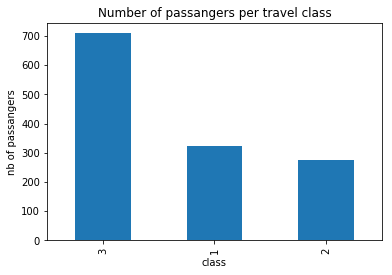

In [178]:
""""count the number of passangers per class and represent it in a histogram"""
plot_class = data_titanic.pclass.value_counts().plot(kind='bar', title='Number of passangers per travel class')
plot_class.set_xlabel("class")
plot_class.set_ylabel("nb of passangers")

# Embarkation port

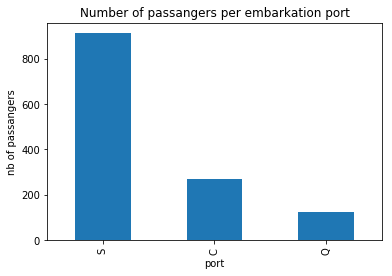

In [179]:
"""add a random embarkation port when it is missing"""
data_titanic.embarked.fillna(random.choice(['S','C','Q']))
plot_port = data_titanic.embarked.value_counts().plot(kind='bar', title='Number of passangers per embarkation port')
plot_port.set_xlabel("port")
plot_port.set_ylabel("nb of passangers")

# Sex

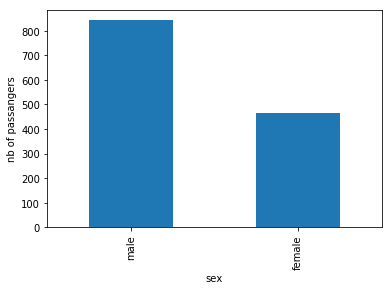

In [180]:
"""count the number of people of each sex"""
plot_sex = data_titanic.sex.value_counts().plot(kind='bar', title='')
plot_sex.set_xlabel("sex")
plot_sex.set_ylabel("nb of passangers")

# Age

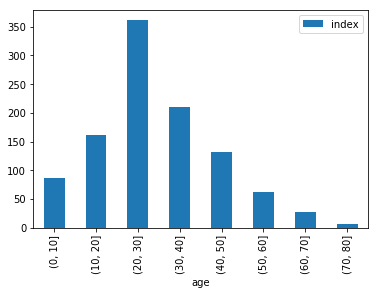

In [181]:
"""drop all the fields with missing age and associate every age with the decade interval it is in"""
a = pd.cut(data_titanic.age.dropna(), [0,10,20,30,40,50,60,70,80])
b = pd.DataFrame(a).reset_index()
c = b.groupby('age').count()
c.plot(kind="bar")



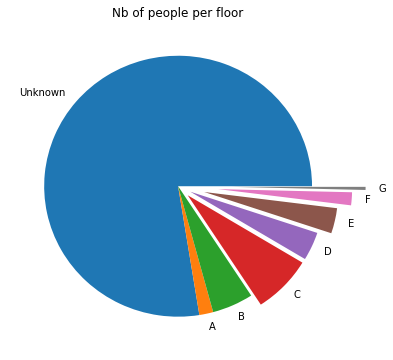

In [182]:
"""I assume we only have the following floors and I don't take into consideration the fields that don't have a 
valid cabin number """
floors = ['A','B','C','D','E','F','G']
cabins = data_titanic.cabin.dropna()
data_titanic['floor']= data_titanic['cabin'].apply(lambda x: str(x)[0] if str(x)[0] in floors else 'Unknown')

explode = [0, 0,0,0.1,0.1,0.2,0.3,0.4]
floor_groups = data_titanic[['floor', 'nb_people']].groupby(['floor']).size()
series_floors = pd.Series(floor_groups, index=['Unknown','A','B','C','D','E','F','G'], name='')
series_floors.plot.pie(figsize=(6, 6), title = 'Nb of people per floor',explode = explode)



In [183]:
"""calculate the number of people per travel class"""
nb_people_1 = data_titanic[pclass == 1]['pclass'].count()
nb_people_2 = data_titanic[pclass == 2]['pclass'].count()
nb_people_3 = data_titanic[pclass == 3]['pclass'].count()

"""calculate the number of people that survived and group it by class"""
survived_class = data_titanic[data_titanic.survived == 1][['pclass','nb_people']].groupby(['pclass']).size()
"""normalise the nb of people that survived by class"""
series_class1 = pd.Series([survived_class[1]/nb_people_1, 1- survived_class[1]/nb_people_1], name ='', index = ["survived", "dead"])
series_class2 = pd.Series([survived_class[2]/nb_people_2, 1- survived_class[2]/nb_people_2],name = '',index = ["survived", "dead"])                          
series_class3 = pd.Series([survived_class[3]/nb_people_3,1 -survived_class[3]/nb_people_3 ], name = '',index = ["survived", "dead"])



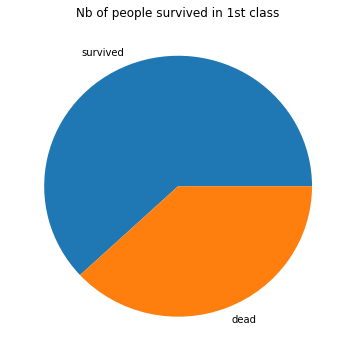

In [184]:
series_class1.plot.pie(figsize=(6, 6), title = 'Nb of people survived in 1st class')

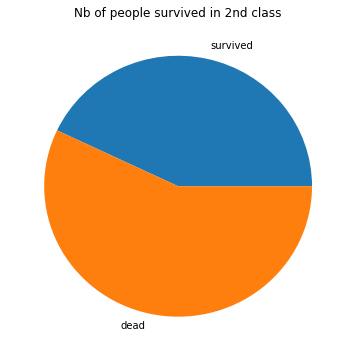

In [185]:
series_class2.plot.pie(figsize=(6, 6), title = 'Nb of people survived in 2nd class')

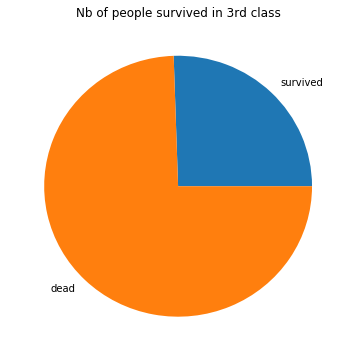

In [186]:
series_class3.plot.pie(figsize=(6, 6), title = 'Nb of people survived in 3rd class')

sex,female,male
pclass,,
1,0.278,0.122
2,0.188,0.050
3,0.212,0.150


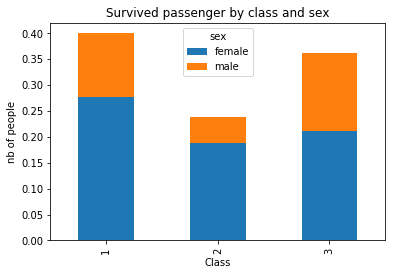

In [187]:
"""nb of people that survived by class and sex"""
s_sex_class = data_titanic[data_titanic.survived == 1][['pclass','sex','nb_people']].groupby(['pclass','sex'])['pclass'].count().unstack('sex')
"""normalise"""
s_sex_class = s_sex_class/data_titanic[data_titanic.survived== 1]['nb_people'].count()

plot_s = s_sex_class.plot(kind='bar', stacked=True)
plot_s.set_xlabel('Class')
plot_s.set_ylabel('nb of people')
plot_s.set_title('Survived passenger by class and sex')
s_sex_class

In [188]:
age = data_titanic['age'].dropna()
"""divide people by age in two intervals: younger than 28 and older than 28"""
age_cut = pd.cut(age, [0,28,80], 
                  labels=['<28', '>=28'], include_lowest=True)
"""add a new field age-cat"""
data_titanic['age-cat'] = age_cut
catsdata = data_titanic[['age-cat']]
data_titanic[['age-cat', 'nb_people']].groupby(['age-cat']).sum()

,nb_people
age-cat,
<28,536
>=28,510


In [189]:
"""nb of people that survived by age category class and sex"""
survived = data_titanic[data_titanic.survived == 1][['pclass','nb_people','sex','age-cat']].groupby(['age-cat','pclass','sex']).sum()
survived

nb_people
age-cat pclass sex              
<28     1      female         39
               male           17
        2      female         51
               male           16
        3      female         56
               male           41
>=28    1      female         89
               male           36
        2      female         41
               male            7
        3      female         16
               male           18